In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD
from altaipony.wheatland import calculate_joint_posterior_distribution, gaussian_prior



for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [2]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [12]:
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")

In [3]:
hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]
df[hasflares].shape

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(3850, 25)

In [4]:
with open(f"{paperdir}values/sso_fraction.txt", "w") as f:
    f.write(f"{144 / (144 + df[hasflares].shape[0]) * 100.:.1f}~\%")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [5]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")
labels = ["2500-3000","3000-3250","3250-3500",
          "3500-3750","3750-4000","4000-5000",
          "5000-6000"]
Mmid  = [0.097, .19, .36, .47, .55, .71, .94]
masses = pd.DataFrame({"Teff_median" : labels,
                       "M_Msun" : Mmid})

params = pd.read_csv("cluster_parameters_merged.csv")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T = T.merge(masses, how="left", on="Teff_median")
T = T.merge(params[["cluster","age (Myr)"]], how="left", on="cluster")
assert T.LC_time_years.sum() - tobs < 1e-10
T.head()

Total observing time: 615.34 years!


,Teff_median,cluster,LC_time_years,M_Msun,age (Myr)
0,2500-3000,hyades,3.201118,0.097,690.0
1,2500-3000,ngc2682,NaN,0.097,3639.0
2,2500-3000,ngc6774,NaN,0.097,2650.0
3,2500-3000,pleiades,9.734428,0.097,135.0
4,2500-3000,praesepe,4.740475,0.097,750.0


# Davenport 2019 Gyro-flare model

In [6]:
def gyroflaremodel(t, m):
    '''From table in Davenport+2019'''
    a1, a2, a3 = -.07, .79, -1.06
    b1, b2, b3 = 2.01, -25.15, 33.99
    alpha = a1 * np.log10(t) + a2 * m + a3
    beta = b1 * np.log10(t) + b2 * m + b3
    return np.array([alpha, beta, t, m])


s = T.apply(lambda x: gyroflaremodel(x["age (Myr)"], x["M_Msun"]), axis=1)
s = pd.DataFrame(s.tolist(), columns=['alpha', 'beta', "age (Myr)", "M_Msun"])
T = T.merge(s, how="left", on=[ "age (Myr)", "M_Msun"])
T.dropna(how="any").tail()

,Teff_median,cluster,LC_time_years,M_Msun,age (Myr),alpha,beta
30,5000-6000,hyades,1.413358,0.94,690.0,-0.516119,16.055087
31,5000-6000,ngc2682,42.053730,0.94,3639.0,-0.566669,17.506574
32,5000-6000,ngc6774,6.491958,0.94,2650.0,-0.557027,17.229724
33,5000-6000,pleiades,14.005932,0.94,135.0,-0.466523,14.630971
34,5000-6000,praesepe,41.611054,0.94,750.0,-0.518654,16.127873


# Full sample FFD plots with $E_\mathrm{kp}$ and $ED$


In [7]:
resfullsample = {}

961
961


100%|██████████| 200/200 [00:03<00:00, 58.10it/s]


Fitted power law alpha=2.097552465979046(0.03525802131342859/0.034845474596048476)
Fitted power law beta=2022.57401146152(599.773911125927/460.4972393302587)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


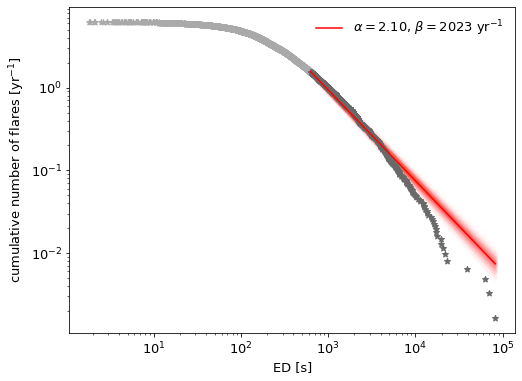

In [8]:
fig, ax =  plt.subplots(1, figsize=(8,6))

hasflares = (df.real==1) & (df.todrop.isnull())
ffd = FFD(f=df[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="darkgrey", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]
print(len(ffd.ed))
ffd.alpha_prior = 1.99
ffd.beta_prior = 981.75
BFA = ffd.fit_mcmc_powerlaw(steps=200)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300, linewidth=5, c="tomato", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="*", c="dimgrey", )#label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="r", 
                            label=(fr"$\alpha=${ffd.alpha:.2f}, "
                                   fr"$\beta=${int(np.rint(ffd.beta))}" + r" yr$^{-1}$"))

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

resfullsample["alpha"] = ffd.alpha
resfullsample["alpha_up_err"] = ffd.alpha_up_err
resfullsample["alpha_low_err"] = ffd.alpha_low_err
resfullsample["beta"] = ffd.beta
resfullsample["beta_up_err"] = ffd.beta_up_err
resfullsample["beta_low_err"] = ffd.beta_low_err
resfullsample["nflares_tot"] = len(ed)
resfullsample["nflares_for_fit"] = len(ffd.ed)
resfullsample["ispowerlaw"] = ispowerlaw
resfullsample["istruncated"] = truncated
resfullsample["ED_min"] = thresh
resfullsample["ED_max"] = np.max(ffd.ed)

plt.savefig(f"plots/{tstamp}_full_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_ED_wheatland.png", dpi=300)

In [9]:
df

628.551765450654

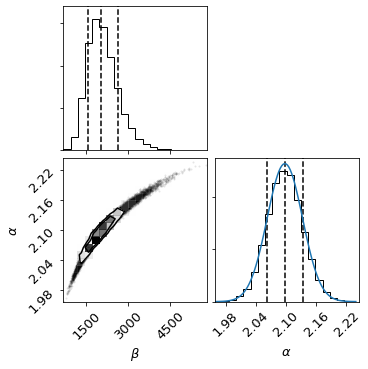

In [10]:
BFA.show_corner_plot(show_truths=False, show_titles=False)


x = np.linspace(resfullsample["alpha"] - resfullsample["alpha_low_err"]*4,
                resfullsample["alpha"] + resfullsample["alpha_up_err"]*4,100)
plt.plot(x, 465*gaussian_prior(x, resfullsample["alpha"], 
                            (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_ED_FFD_cornerplot.png", dpi=300)

In [11]:
def loglikelihood_gauss_wheatland_ed(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha"], 
                           (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [12]:
with open(f"{paperdir}values/gauss_wheatland_alpha_mu.txt", "w") as f:
    f.write(str(resfullsample["alpha"]))
with open(f"{paperdir}values/gauss_wheatland_alpha_sigma.txt", "w") as f:
    f.write(str((resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))

1213


100%|██████████| 200/200 [00:03<00:00, 53.60it/s]


Fitted power law alpha=1.9844937242644916(0.028753743911472895/0.02802593755215832)
Fitted power law beta=4.0124294310657635e+32(3.214521872378228e+33/3.5455265286912375e+32)


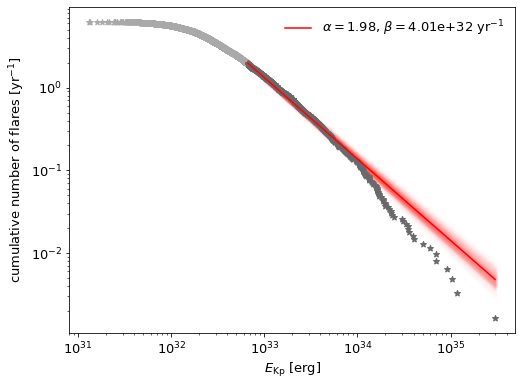

In [13]:
fig, ax =  plt.subplots(1, figsize=(8,6))
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares & ~(df.ed_rec.isnull())], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="darkgrey", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

ffd.alpha_prior = 1.85
ffd.beta_prior = 1.75e28
BFA = ffd.fit_mcmc_powerlaw(steps=200.)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300,linewidth=5, c="tomato", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="*", c="dimgrey")#, label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="r", label=fr"$\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"  + r" yr$^{-1}$")


resfullsample["alpha_en"] = ffd.alpha
resfullsample["alpha_up_err_en"] = ffd.alpha_up_err
resfullsample["alpha_low_err_en"] = ffd.alpha_low_err
resfullsample["beta_en"] = ffd.beta
resfullsample["beta_up_err_en"] = ffd.beta_up_err
resfullsample["beta_low_err_en"] = ffd.beta_low_err
resfullsample["nflares_tot_en"] = len(ed)
resfullsample["nflares_for_fit_en"] = len(ffd.ed)
resfullsample["ispowerlaw_en"] = ispowerlaw
resfullsample["istruncated_en"] = truncated
resfullsample["EKp_min"] = thresh
resfullsample["EKp_max"] = np.max(ffd.ed)

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"$E_\mathrm{Kp}$ [erg]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

plt.savefig(f"plots/{tstamp}_full_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_energy_wheatland.png", dpi=300)

In [16]:
thresh

6.625409284096966e+32

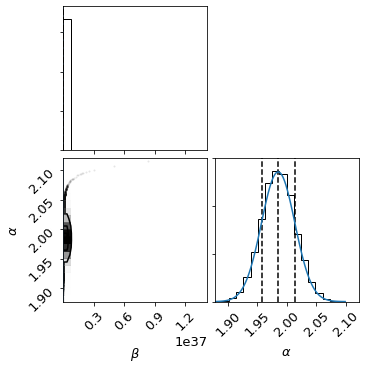

In [17]:
BFA.show_corner_plot(show_truths=False, show_titles=False)
x = np.linspace(resfullsample["alpha_en"] - resfullsample["alpha_low_err_en"]*4,
                resfullsample["alpha_en"] + resfullsample["alpha_up_err_en"]*4,100)
plt.plot(x, 385*gaussian_prior(x, resfullsample["alpha_en"], 
                            (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_energy_FFD_cornerplot.png", dpi=300)

In [23]:
def loglikelihood_gauss_wheatland_energy(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha_en"], 
                           (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [17]:
_t = pd.Series(resfullsample)
resfulltab =  pd.DataFrame({"space": [r"$ED$", r"$E_\mathrm{Kp}$"],
              r"$\alpha$":[f"${_t.alpha:.2f}\left(OK1{_t.alpha_up_err:.2f}K2UK1{_t.alpha_up_err:.2f}K2\right)$",
                           f"${_t.alpha_en:.2f}\left(OK1{_t.alpha_up_err_en:.2f}K2UK1{_t.alpha_up_err_en:.2f}K2\right)$",],
              r"$\beta$ [yr$^{-1}$]":[f"${int(np.rint(_t.beta))}\left(OK1{int(np.rint(_t.beta_up_err))}K2UK1{int(np.rint(_t.beta_low_err))}K2\right)$",
                          f"${_t.beta_en/10**32:.2f}\left(OK1{_t.beta_up_err_en/10**32:.2f}K2UK1{_t.beta_low_err_en/10**32:.2f}K2\right)" + r"\cdot 10^{32}$"],
              r"$n_\mathrm{tot}$":[_t.nflares_tot,_t.nflares_tot_en,],
              r"$n_\mathrm{fit}$":[_t.nflares_for_fit,_t.nflares_for_fit_en,],
              r"min.":[f"{int(np.rint(_t.ED_min))} s",f"${_t.EKp_min/10**32:.2f}" + r"\cdot 10^{32}$ erg",],
              r"max.":[f"{int(np.rint(_t.ED_max))} s",f"${_t.EKp_max/10**35:.2f}" + r"\cdot 10^{35}$ erg",]
             })
_t.to_csv("tables/full_sample_alphabeta.csv")

In [18]:
resfulltab[r"$\alpha$"] = (resfulltab[r"$\alpha$"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

resfulltab[r"$\beta$ [yr$^{-1}$]"] = (resfulltab[r"$\beta$ [yr$^{-1}$]"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))
names = resfulltab['space'].values
resfulltab = resfulltab.T

resfulltab = resfulltab.rename(index=str, columns=dict(zip(resfulltab.columns.values, names)))
resfulltab = resfulltab.drop("space")
nc = 'c' * (resfulltab.shape[1])
stri = resfulltab.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("{}"," " )

with open(f"{paperdir}tables/powerlaw_fullsample_wheatland.tex", "w") as f:
    f.write(stri)

print(stri)

\begin{tabular}{lccr}
\hline
  &                               $ED$ &                                  $E_\mathrm{Kp}$ \\
\hline
$\alpha$            &  $2.10\left(^{0.04}_{0.04}\right)$ &                $1.98\left(^{0.03}_{0.03}\right)$ \\
$\beta$ [yr$^{-1}$] &    $2023\left(^{600}_{460}\right)$ &  $4.01\left(^{32.15}_{3.55}\right)\cdot 10^{32}$ \\
$n_\mathrm{tot}$    &                               3844 &                                             3844 \\
$n_\mathrm{fit}$    &                                961 &                                             1213 \\
min.                &                              629 s &                          $6.63\cdot 10^{32}$ erg \\
max.                &                            82185 s &                          $3.01\cdot 10^{35}$ erg \\
\hline

\end{tabular}



In [19]:
with open(f"{paperdir}values/MCMC_alpha_ed.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha"],2)))
with open(f"{paperdir}values/MCMC_alpha_energy.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha_en"],2)))

## Teff bins


In [20]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
numer = ["a.","b.","c.","d.","e.","f.","g."]

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


12


100%|██████████| 200/200 [00:02<00:00, 76.92it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.099049183236374(0.0344902169261192/0.03424636091777167)
Fitted power law beta=2803.076429497163(1290.5425883879511/916.0243985771972)
9


100%|██████████| 200/200 [00:02<00:00, 75.94it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0973614790434967(0.03451538143102706/0.03468721154392185)
Fitted power law beta=8102.433642186232(4201.762760730815/2853.763668790052)
4


100%|██████████| 200/200 [00:02<00:00, 77.50it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=2.098660142233366(0.034714236003764665/0.03446948675798556)
Fitted power law beta=2427.2509978873286(1588.056240486996/1043.3668902494005)
258


100%|██████████| 200/200 [00:02<00:00, 67.84it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0887739751190555(0.03058729521652337/0.03087933975053314)
Fitted power law beta=4842.452927093955(1262.598911324515/1011.876207070829)
76


100%|██████████| 200/200 [00:02<00:00, 73.02it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0808377879965523(0.03363224162135481/0.03332703645635515)
Fitted power law beta=2618.465668436772(709.1763909668252/570.9729251482527)
275


100%|██████████| 200/200 [00:02<00:00, 66.82it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=2.0757589708498854(0.03124719615194671/0.030671591052848335)
Fitted power law beta=2739.6489780646048(743.3384194787363/578.738097229375)
310


100%|██████████| 200/200 [00:03<00:00, 65.58it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0762440682709755(0.030739145997737527/0.029936125466299313)
Fitted power law beta=3487.663489476315(771.0355805631648/631.3373161233926)
83


100%|██████████| 200/200 [00:02<00:00, 73.69it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.092642347009638(0.0337831491212488/0.033223413934400536)
Fitted power law beta=2130.6606173671007(542.0754161596165/426.2488484856408)
612


100%|██████████| 200/200 [00:03<00:00, 58.59it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.016983003689051(0.02689089906469766/0.02622305164637595)
Fitted power law beta=1153.2854279849498(211.46474498707562/173.5900962003368)
4


100%|██████████| 200/200 [00:02<00:00, 76.37it/s]


Fitted power law alpha=2.0985755803837645(0.03487279198892956/0.0346853126644886)
Fitted power law beta=326.8847388778718(193.0760632579042/132.1322947261359)
69


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 72.71it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroup

Fitted power law alpha=2.0985271915038246(0.03317420914525515/0.03344387709946828)
Fitted power law beta=1800.276036366912(440.45752284725745/357.4627949466312)
28


100%|██████████| 200/200 [00:02<00:00, 72.63it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.097627429987738(0.03472455947061759/0.034150723032139396)
Fitted power law beta=1340.3638416292224(400.201496543104/315.8549972620974)
74


100%|██████████| 200/200 [00:02<00:00, 71.12it/s]


Fitted power law alpha=2.0844192570031828(0.0336514845076783/0.033503544525303575)
Fitted power law beta=180.98909285379716(38.84481550837225/32.80793607980911)
35


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 72.61it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroup

Fitted power law alpha=2.105942375403238(0.034013709512876744/0.033988661049781044)
Fitted power law beta=1346.790596754473(380.53344084214996/300.0874447497911)
10


100%|██████████| 200/200 [00:02<00:00, 76.07it/s]


Fitted power law alpha=2.0990613255753368(0.034459419300015615/0.03447784379873653)
Fitted power law beta=64.63395480331795(26.12310420228414/19.555094398797102)
55


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 72.88it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroup

Fitted power law alpha=2.0931588463827877(0.03392100254810915/0.033829327232258066)
Fitted power law beta=935.9610341995478(246.20063477441795/197.02107585616727)
7


100%|██████████| 200/200 [00:02<00:00, 73.59it/s]


Fitted power law alpha=2.0969242534942856(0.03461964337347245/0.03454261877515741)
Fitted power law beta=21.21671631984087(9.24259342580406/6.983072333076251)
47


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/wheatland.py:300: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 200/200 [00:02<00:00, 73.82it/s]


Fitted power law alpha=2.0827168377149365(0.03386884033458637/0.03401234362209227)
Fitted power law beta=17.235078679965696(3.3466071661947367/2.8740671037664214)
19


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 73.59it/s]


Fitted power law alpha=2.0903479346798504(0.034711039485606054/0.03468897444222119)
Fitted power law beta=71.35267541975182(21.63006665878345/17.429760797384162)
42


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 71.14it/s]


Fitted power law alpha=2.097410823706251(0.03451566731348299/0.034167719117838224)
Fitted power law beta=21.73242025940749(4.634881747986675/3.8843907265422004)
4


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:02<00:00, 76.28it/s]


Fitted power law alpha=2.0985445459039545(0.034412664833261886/0.03491930494586093)
Fitted power law beta=65.52653233783371(38.78615980791649/26.60861138315323)
1


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 77.19it/s]


Fitted power law alpha=2.098504597751189(0.03465112469466192/0.03483405296419528)
Fitted power law beta=3.8627055775111856(3.9281913349931843/2.2488526703144416)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))


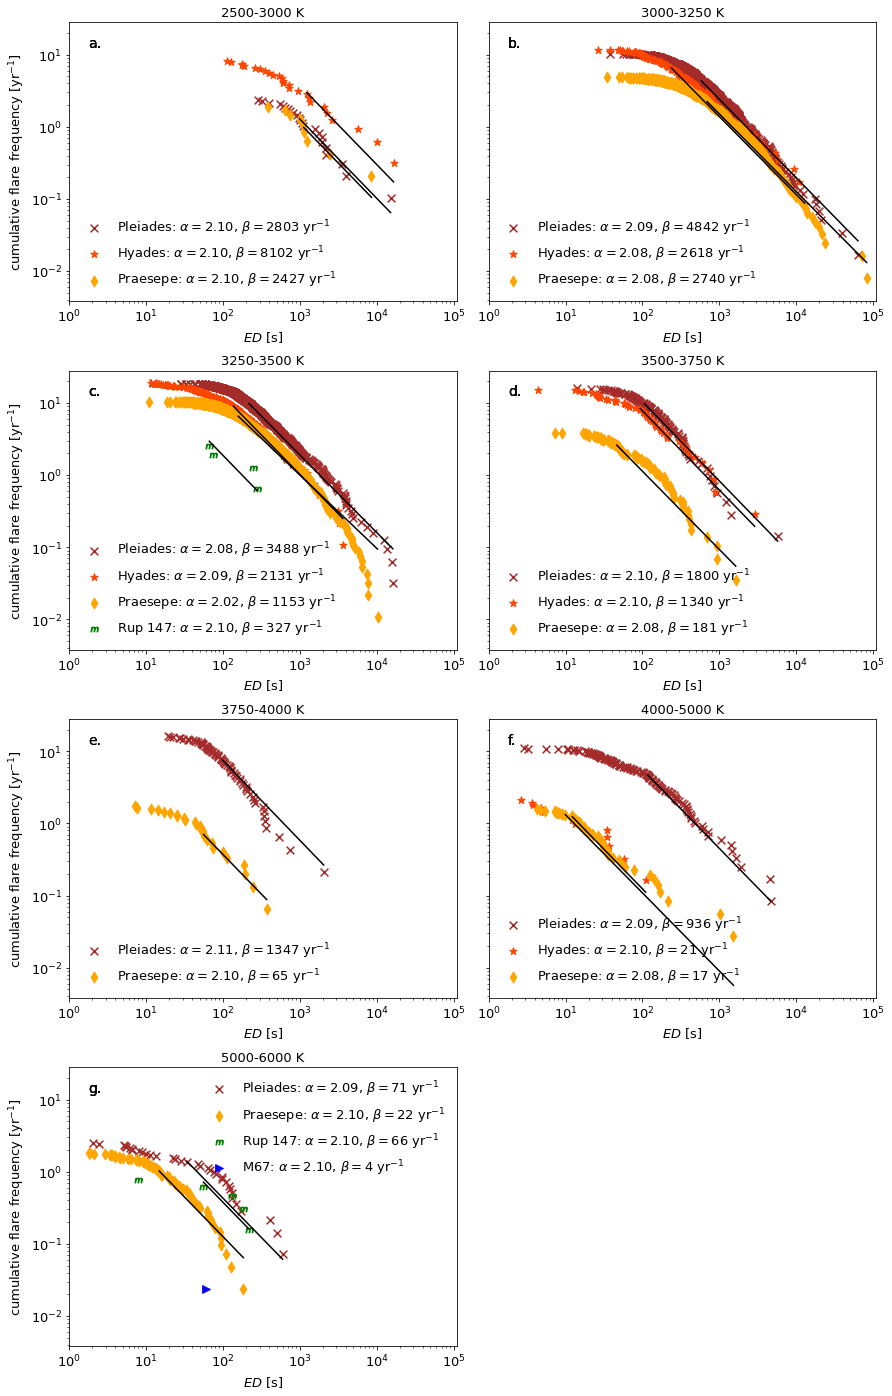

In [21]:
resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,19.5), sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    resed[i]={}
    for j, h in g.groupby("cluster"):

        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha"]
            ffd.beta_prior = resfullsample["beta"]

            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
            print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
            
                
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"alpha":ffd.alpha,
                                  "alpha_up_err":ffd.alpha_up_err,
                                  "alpha_low_err":ffd.alpha_low_err,
                                  "beta":ffd.beta,
                                  "beta_up_err":ffd.beta_up_err,
                                  "beta_low_err":ffd.beta_low_err,
                                  "nflares":len(ed),
                                  "nfit":len(ffd.ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw":ffd.is_powerlaw(),
                                  "istruncated": ffd.is_powerlaw_truncated(),
                                  "ED_min": thresh,
                                  "ED_max": np.max(ffd.ed)
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                            label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.0f}" + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            if k==6:
                axes[k].legend(loc=1, frameon=False)
            else:
                axes[k].legend(loc=3, frameon=False)

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

12


100%|██████████| 200/200 [00:02<00:00, 78.18it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=6.99e+31(5.03e+32/6.16e+31)
13


100%|██████████| 200/200 [00:02<00:00, 77.46it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.74e+32(1.24e+33/1.53e+32)
4


100%|██████████| 200/200 [00:02<00:00, 75.38it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=7.23e+31(5.66e+32/6.41e+31)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


311


100%|██████████| 200/200 [00:03<00:00, 66.13it/s]


Fitted power law alpha=2.00(0.03/0.02)
Fitted power law beta=1.09e+33(6.27e+33/9.25e+32)
78


100%|██████████| 200/200 [00:02<00:00, 73.78it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.65e+32(1.14e+33/1.44e+32)
302


100%|██████████| 200/200 [00:03<00:00, 66.63it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=3.89e+32(2.26e+33/3.32e+32)
327


100%|██████████| 200/200 [00:03<00:00, 64.24it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.00(0.03/0.03)
Fitted power law beta=3.16e+33(1.80e+34/2.70e+33)
90


100%|██████████| 200/200 [00:02<00:00, 68.13it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=4.80e+32(3.22e+33/4.18e+32)
663


100%|██████████| 200/200 [00:03<00:00, 56.51it/s]


Fitted power law alpha=1.97(0.02/0.02)
Fitted power law beta=1.68e+32(7.55e+32/1.37e+32)
4


100%|██████████| 200/200 [00:02<00:00, 78.32it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=8.75e+31(6.86e+32/7.72e+31)
75


100%|██████████| 200/200 [00:02<00:00, 74.01it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.54e+33(1.08e+34/1.35e+33)
20


100%|██████████| 200/200 [00:02<00:00, 76.10it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.79e+33(1.35e+34/1.59e+33)
76


100%|██████████| 200/200 [00:02<00:00, 73.49it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.05e+32(7.48e+32/9.23e+31)
36


100%|██████████| 200/200 [00:02<00:00, 75.87it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=5.70e+33(4.46e+34/5.02e+33)
16


100%|██████████| 200/200 [00:02<00:00, 75.87it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=2.73e+32(2.03e+33/2.42e+32)
59


100%|██████████| 200/200 [00:02<00:00, 75.33it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=3.38e+33(2.61e+34/2.99e+33)
6


100%|██████████| 200/200 [00:02<00:00, 77.28it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.51e+32(1.14e+33/1.35e+32)
37


100%|██████████| 200/200 [00:02<00:00, 74.73it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.18e+32(8.64e+32/1.05e+32)
19


100%|██████████| 200/200 [00:02<00:00, 75.31it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.80e+33(1.48e+34/1.60e+33)
44


100%|██████████| 200/200 [00:02<00:00, 74.72it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=4.15e+32(3.08e+33/3.67e+32)
4


100%|██████████| 200/200 [00:02<00:00, 76.91it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.32e+33(1.11e+34/1.19e+33)
1


100%|██████████| 200/200 [00:02<00:00, 81.84it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=7.24e+31(6.69e+32/6.57e+31)


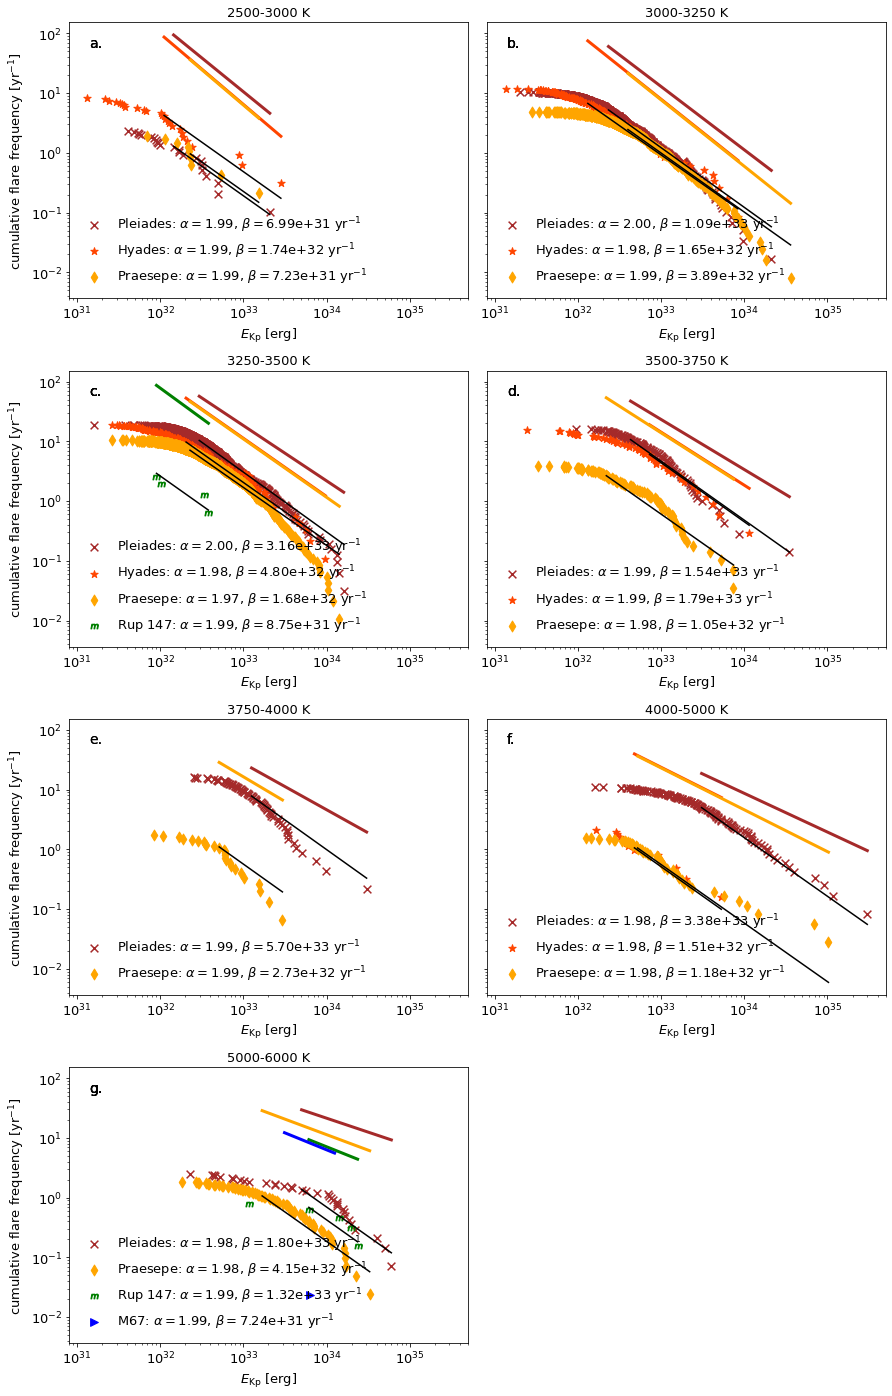

In [43]:
resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha_en"]
            ffd.beta_prior = resfullsample["beta_en"]
            
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_energy)
            print(f"Fitted power law alpha={ffd.alpha:.2f}({ffd.alpha_up_err:.2f}/{ffd.alpha_low_err:.2f})")
            print(f"Fitted power law beta={ffd.beta:.2e}({ffd.beta_up_err:.2e}/{ffd.beta_low_err:.2e})")
            
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            # Add Davenport model
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * (A - 1.) * 365.25
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            if len(ffdd.ed) == 1:
                ffdd.ed = [ffdd.ed/2.,ffdd.ed*2.]
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3)
            # ----------------------------------------------------------------
            resen[i][ccol[j][0]]= {"alpha_en":ffd.alpha,
                                  "alpha_up_err_en":ffd.alpha_up_err,
                                  "alpha_low_err_en":ffd.alpha_low_err,
                                  "beta_en":ffd.beta,
                                  "beta_up_err_en":ffd.beta_up_err,
                                  "beta_low_err_en":ffd.beta_low_err,
                                  "nflares_en":len(ed),
                                  "nfit_en":len(ffd.ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw_en":ffd.is_powerlaw(),
                                  "istruncated_en": ffd.is_powerlaw_truncated(),
                                  "davenport_alpha": A,
                                  "davenport_beta":B,
                                  "EKp_min": thresh,
                                  "EKp_max": np.max(ffd.ed)
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"   + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            axes[k].legend(loc=3,frameon=False)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

In [44]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta.to_csv("tables/cluster_SpT_alphabeta.csv",index=False)
beta.sort_values(by="nflares")

,Teff,cluster,alpha,alpha_up_err,alpha_low_err,beta,beta_up_err,beta_low_err,nflares,nfit,...,ispowerlaw_en,istruncated_en,davenport_alpha,davenport_beta,EKp_min,EKp_max,Tmin,Tmax,Tmid,Tmid_err
21,5000-6000,M67,2.0985,0.0346511,0.0348341,3.86271,3.92819,2.24885,1,1,...,False,True,1.56667,6.64498e+19,6.24825e+33,6.24825e+33,5000,6000,5500,500
9,3250-3500,Rup 147,2.09858,0.0348728,0.0346853,326.885,193.076,132.132,4,4,...,True,False,2.01523,2.43152e+34,9.01094e+31,3.79554e+32,3250,3500,3375,125
20,5000-6000,Rup 147,2.09854,0.0344127,0.0349193,65.5265,38.7862,26.6086,5,4,...,True,False,1.55703,3.45295e+19,6.13186e+33,2.36476e+34,5000,6000,5500,500
2,2500-3000,Praesepe,2.09866,0.0347142,0.0344695,2427.25,1588.06,1043.37,9,4,...,True,False,2.18462,9.23621e+39,2.30158e+32,1.52777e+33,2500,3000,2750,250
16,4000-5000,Hyades,2.09692,0.0346196,0.0345426,21.2167,9.24259,6.98307,13,7,...,True,False,1.69782,1.76165e+24,4.76516e+32,5.28102e+33,4000,5000,4500,500
0,2500-3000,Pleiades,2.09905,0.0344902,0.0342464,2803.08,1290.54,916.024,23,12,...,True,False,2.13249,2.8122e+38,1.44722e+32,2.07785e+33,2500,3000,2750,250
14,3750-4000,Praesepe,2.09906,0.0344594,0.0344778,64.634,26.1231,19.5551,26,10,...,True,False,1.82675,2.60819e+28,5.11578e+32,2.94861e+33,3750,4000,3875,125
1,2500-3000,Hyades,2.09736,0.0345154,0.0346872,8102.43,4201.76,2853.76,26,9,...,True,False,2.18209,7.7943e+39,1.11222e+32,2.82428e+33,2500,3000,2750,250
18,5000-6000,Pleiades,2.09035,0.034711,0.034689,71.3527,21.6301,17.4298,35,19,...,True,False,1.46652,7.28508e+16,5.01677e+33,6.01959e+34,5000,6000,5500,500
11,3500-3750,Hyades,2.09763,0.0347246,0.0341507,1340.36,400.201,315.855,52,28,...,True,False,1.88742,2.43392e+30,7.23818e+32,1.14162e+34,3500,3750,3625,125


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


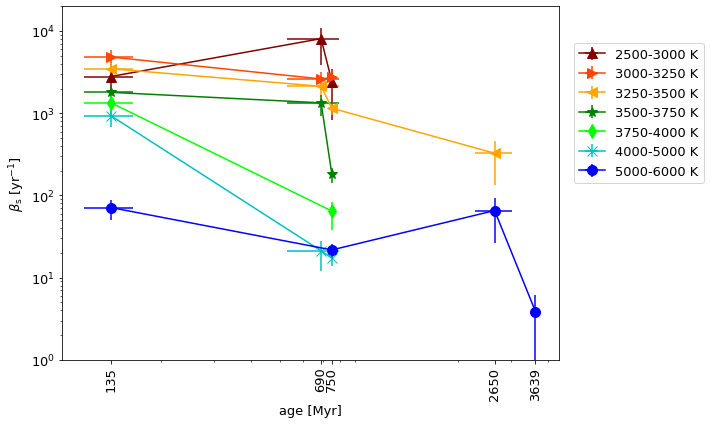

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x=g.age, xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g.beta, yerr=g[["beta_up_err","beta_low_err"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],markersize=10)
#     g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
#            label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
#           marker=Tcols[str(label)][0],markersize=10)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta_\mathrm{s}$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.set_ylim(1,2e4)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

In [48]:
beta_s = betaen_.merge(betaed_, left_index=True,right_index=True)
for b in ["beta","beta_up_err","beta_low_err",
          "beta_en","beta_up_err_en", "beta_low_err_en",
          "ED_min","ED_max","EKp_min","EKp_max"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)

# Formatting of beta values
    
for out, beta, beta_up_err, beta_low_err in [(r"$\beta_\mathrm{s}$ [yr$^{-1}$]","beta","beta_up_err", "beta_low_err"),
                                             (r"$\beta_\mathrm{erg}$ [yr$^{-1}$]","beta_en","beta_up_err_en", "beta_low_err_en"),
                                           
                            ]:
    if out == r"$\beta_\mathrm{erg}$ [yr$^{-1}$]":
        beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_up_err]))+2).astype(int)
        beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
        beta_s["berr"] = (np.rint(np.log10(beta_s[beta_up_err]))).astype(int)
        beta_s["B"] = beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
        beta_s["Berr_up"] = beta_s.apply(lambda x: np.round(x[beta_up_err]/10**x.b, x.perr), axis=1)     
        beta_s["Berr_low"] = beta_s.apply(lambda x: np.round(x[beta_low_err]/10**x.b, x.perr), axis=1) 
    
        beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left(OK1{x.Berr_up}K2UK1{x.Berr_low}K2\right)\cdot 10OK1{x.b}K2$", axis=1)
    else: 
        beta_s[out] = beta_s.apply(lambda x: f"${int(x[beta])}\left(OK1{int(x[beta_up_err])}K2UK1{int(x[beta_low_err])}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

    
# Formatting energy thresholds
for sout, out in [("$E_\mathrm{Kp,min}$ [erg]","EKp_min"),
                  ("$ED_\mathrm{min}$ [s]","ED_min"),
                  ("$E_\mathrm{Kp,max}$ [erg]","EKp_max"),
                  ("$ED_\mathrm{max}$ [s]","ED_max")]:
    beta_s["b"] = (np.rint(np.log10(beta_s[out]))).astype(int)
    beta_s["B"] = beta_s.apply(lambda x: np.round(x[out]/10**x.b, 2).astype(str), axis=1)
    beta_s[sout] = beta_s.apply(lambda x: f"${x.B}\cdot 10OK1{x.b}K2$", axis=1)
    
    beta_s[sout] = (beta_s[sout].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
# Formatting alpha

for out, beta, beta_up_err, beta_low_err in [(r"$\alpha_\mathrm{erg}$","alpha_en","alpha_up_err_en", "alpha_low_err_en"),
                                             (r"$\alpha_\mathrm{s}$","alpha","alpha_up_err", "alpha_low_err"),
                            ]:    
    beta_s[out] = beta_s.apply(lambda x: f"${x[beta]:.2f}\left(OK1{x[beta_up_err]:.2f}K2UK1{x[beta_low_err]:.2f}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
rename = {"nflares":r"$n_\mathrm{tot,s}$",
          "nfit":r"$n_\mathrm{fit,s}$",
          "nflares_en":r"$n_\mathrm{tot,erg}$",
          "nfit_en":r"$n_\mathrm{fit,erg}$",
         }

beta_s = beta_s[[r"$\alpha_\mathrm{s}$",r"$\beta_\mathrm{s}$ [yr$^{-1}$]",
                 "$ED_\mathrm{min}$ [s]","$ED_\mathrm{max}$ [s]",
                 "nflares","nfit",
                 r"$\alpha_\mathrm{erg}$",r"$\beta_\mathrm{erg}$ [yr$^{-1}$]",
                 "$E_\mathrm{Kp,min}$ [erg]", "$E_\mathrm{Kp,max}$ [erg]",
                 "nflares_en","nfit_en",]].rename(index=str, columns=rename)

beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("\hline\n          &         &    ", "\hline\n $T_\mathrm{eff}$ [K] & cluster &")
with open(f"{paperdir}tables/powerlaw_SpT_wheatland.tex", "w") as f:
    f.write(stri)

# Notes on very old clusters

In [47]:
print(stri)

\begin{tabular}{lccccccccccccr}
\hline
 $T_{eff}$ [K] & cluster &            $\alpha_\mathrm{s}$ &     $\beta_\mathrm{s}$ [yr$^{-1}$] & $ED_\mathrm{min}$ [s] & $ED_\mathrm{max}$ [s] & $n_\mathrm{tot,s}$ & $n_\mathrm{fit,s}$ &              $\alpha_\mathrm{erg}$ &              $\beta_\mathrm{erg}$ [yr$^{-1}$] & $E_\mathrm{Kp,min}$ [erg] & $E_\mathrm{Kp,max}$ [erg] & $n_\mathrm{tot,erg}$ & $n_\mathrm{fit,erg}$ \\
\hline
2500-3000 & Hyades &  $2.10\left(^{0.03}_{0.03}\right)$ &  $8102\left(^{4201}_{2853}\right)$ &    $1.24\cdot 10^{3}$ &    $1.66\cdot 10^{4}$ &                 26 &                  9 &  $1.99\left(^{0.03}_{0.03}\right)$ &  $1.7\left(^{12.4}_{1.5}\right)\cdot 10^{32}$ &       $1.11\cdot 10^{32}$ &       $2.82\cdot 10^{33}$ &                   26 &                   13 \\
          & Pleiades &  $2.10\left(^{0.03}_{0.03}\right)$ &   $2803\left(^{1290}_{916}\right)$ &    $0.99\cdot 10^{3}$ &    $1.52\cdot 10^{4}$ &                 23 &                 12 &  $1.99\left(^{0.03}

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [13]:

df[(df.cluster=="ngc6774") & (df.EPIC==219341906)][["dtp_tot", "EPIC","C",
                                                                    "Teff_median", "ed_rec","note", 
                                                                    "todrop", "real"]]

,dtp_tot,EPIC,C,Teff_median,ed_rec,note,todrop,real
3572,3449.0,219341906,7,5638.81,2.550406,NaN,BP-RP outlier,0
3573,3449.0,219341906,7,5638.81,1.566361,NaN,BP-RP outlier,0
3574,3449.0,219341906,7,5638.81,2.659138,NaN,BP-RP outlier,0
3575,3449.0,219341906,7,5638.81,5.427365,NaN,BP-RP outlier,1
3576,3449.0,219341906,7,5638.81,9.412684,NaN,BP-RP outlier,1


In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

# Compare Shibayama 2013 Kepler superflares to our flares

In [ ]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

In [ ]:
1/800, 1/5000

In [ ]:
800/18, 5000/128

In [ ]:
np.power(1e34,-1.85) * 2.05e27 / .85

In [ ]:
18-130 

## OLD paper vs. NEW paper

In [ ]:
def f(alpha, beta, E):
    return np.power(10,beta) / (alpha-1) * np.power(E,-alpha+1)

In [ ]:
f(1.87, np.log10(.5e29), 1e33)

In [ ]:
resed

In [ ]:
8